**Problem Statement**:
  Imagine we want to create an App that groups music into different categories (e.g. genres) and creates playlists based on these for our users. We already have the App and the infrastructure but we are missing a machine learning model that performs the classification for us. Our research on arxiv.org showed, that we want a multi-modal model with a transformers architecture to achieve state-of-the-art results. The model can be trained on the following data:
1. ID (INT)
2. song description (TEXT) 
3. genre (TEXT) -> (label ids)
4. MP3 (BLOB) -> (huggingface hub)

Your tasks:
1. Please show us how your model would look like. An architecture diagram or actual python code are both fine but do not forget descriptive comments.
2. Write the code that we will need to create the required pytorch Dataloader\s and to perform the training loop. You can omit complex functions and try-except blocks and just describe them with a comment.

**Solution**:
Since music can be classified based on genre, beats, themes, etc. and it is difficult to obtain huge labelled data (for supervised DNNs to work), a self-supervised (to learn music representation with limited labelled data) multi-modal (multiple inputs from similar distributions is similar to more data) transformer (to tackle long range sequence dependence; parallelizable, reduced computations) is proposed.

Two recent papers that were referenced for this work (ATBert): [Parameter Efficient Multimodal Transformers for Video Representation Learning](https://openreview.net/forum?id=6UdQLhqJyFD) (AVBert) and [MusicBERT: A Self-supervised Learning of Music Representation](https://dl.acm.org/doi/pdf/10.1145/3474085.3475576). ATBert (refer pic below) is elicited majorly from AVBert and experimentation results from that paper are referenced to validate choices.

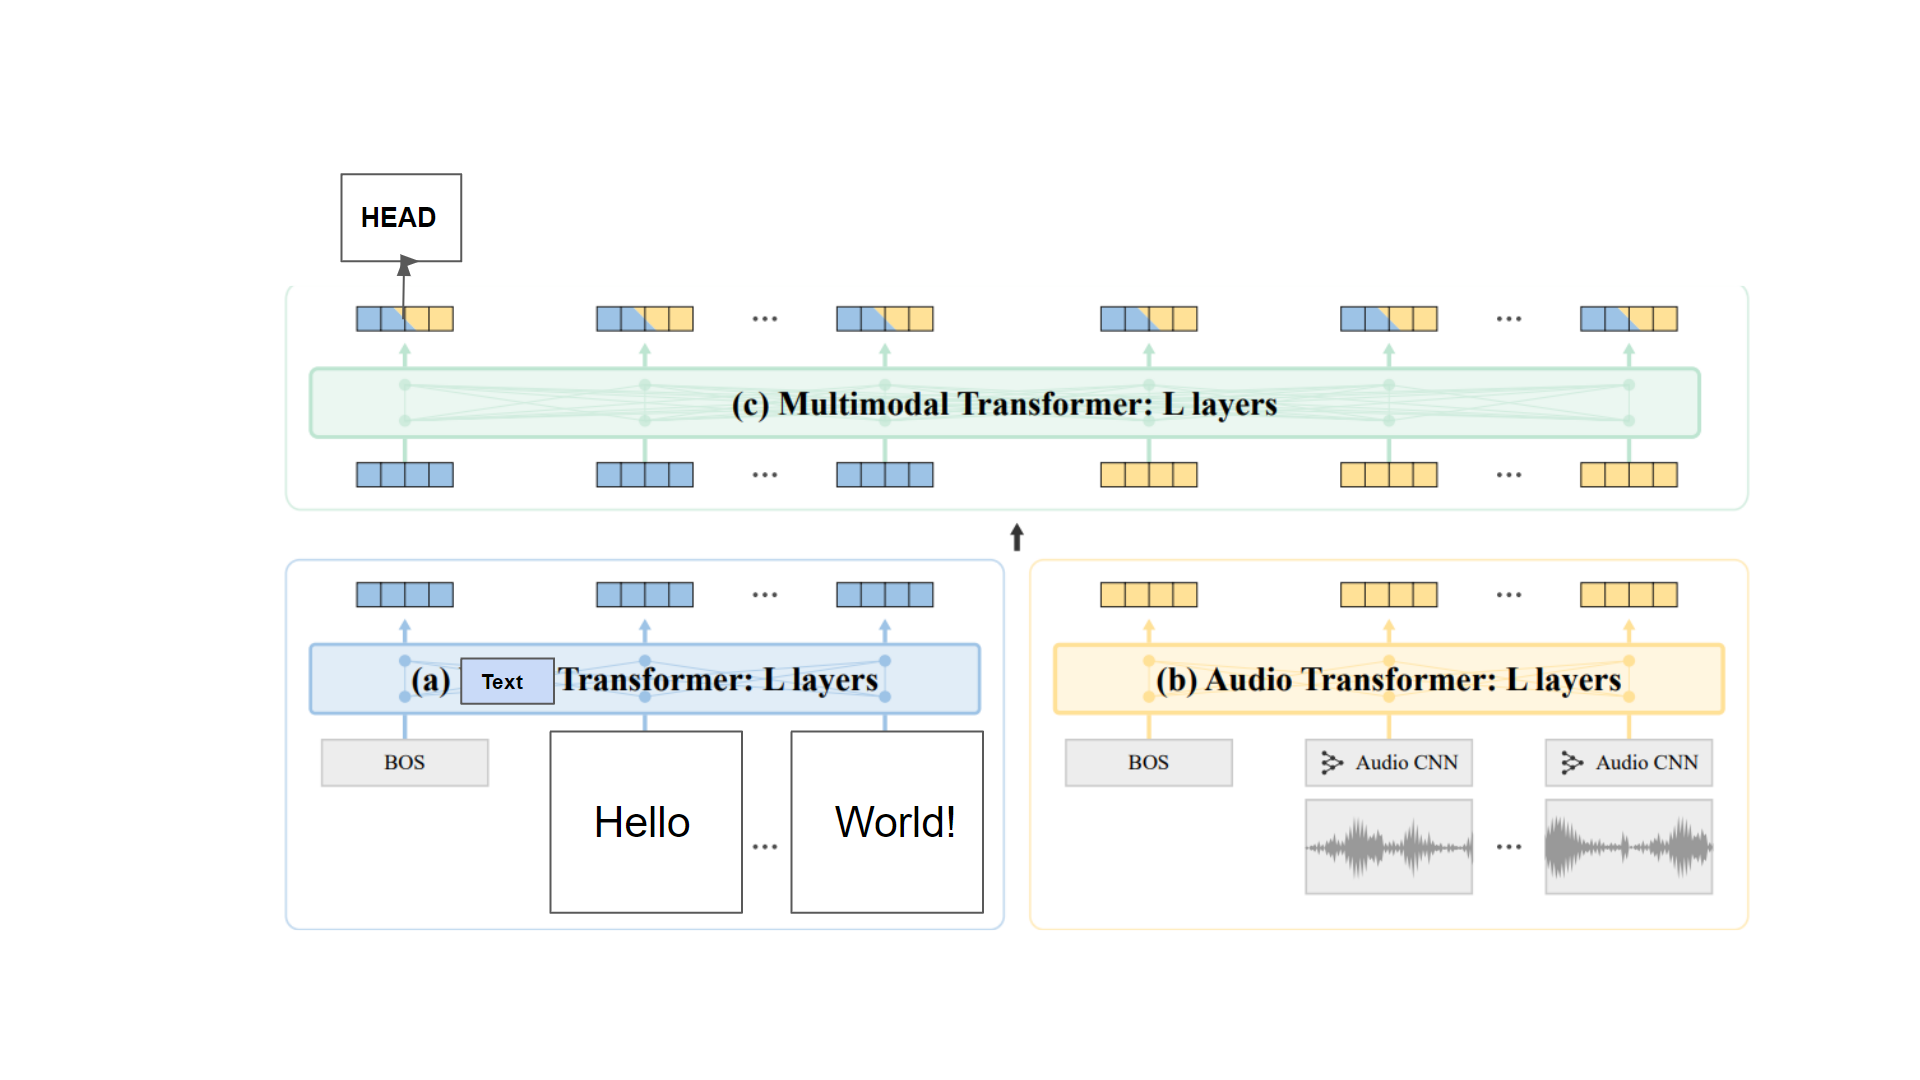

The above model architecture is inspired from AVBert. Modalities could be fused at different levels: early (multi-modal transformer just after audio-CNN), mid (ATBert, AVBert), late (2 uni-modal transformers). Intuitively, an initial common encoder backbone might find it tough to process relatively-raw encoded multi-modal inputs. Mid-fusion approach enjoys four advantages: learning cross-modal relationship after uni-modal encoders project data to a common sub-space, being
robust to missing modalities, achieving overall the best performance (empirical from AVBert) and flexibility to either pre-train the entire model from scratch or train only multi-modal transformer while using pre-trained BERT (text)/ MusicBERT (audio; has it's own "alignment task and reconstruction" pre-training task) weights which may be sub-optimal (previous work in multimodal visual-and-language tasks point out that using partially fixed Transformers of different modalities is detrimental to multimodal
representation learning) but saves on resources.

Audio is pre-processed to log-mel-scaled spectrograms (as done in most of the recent works on audio to capture both analog frequency, time content) after which it is passed through a ResNet-50 CNN to generate local audio embeddings (as mel spectrums have local inductive bias like images). Same [ALBERT-base](https://huggingface.co/transformers/model_doc/albert.html) encoder for 2 uni-modal (audio, text), 1 multi-modal (audio-text) encoding is used to reuse some parameters and reduce resource requirement (as compared to BERT). Learnable positional embeddings are used for all encoder inputs and modalitity-specific embeddings are used for multi-modal encoder input.

As in AVBert, Correct Pair Prediction (CPP) is used to help model learn cross-modal dynamics. Model tries to predict whether a pair of audio-text embeddings corresponds to the same music or different. One binary classifier which takes in audio-text summary embedding (first output token of multi-modal encoder) and a random-time multi-modal encoder output (empirically validated in AVBert) are passed through an external 2 layer, non-linear head to classify. Class imbalance is avoided.

Additionally, an interesting Info-Noise-Contrastive-Estimation (InfoNCE) loss is also used in AVBert where a audio-text pair (with a masked input token) is classified into positive/negative class (self created) where negative classes are sampled from a mini-batch based on a novel CANS-Similar (l2 norm based) method. But InfoNCE loss wasn't implemented here due to lack of proper parallelized implementation description in paper and lack of time.

Hyper parameter tuning wasn't the main focus. "Common-voice" (small Swedish corpus) dataset was used to pre-train the model as it contains both text, audio (and other meta-data) data (but speeches). For fine-tuning, a bi-layer, non-linear head was used to classify audio+text based on genre (small available labelled data) where labels were randomly generated, just to illustrate the flow.

In [ ]:
#import
import re
import math
import random
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

!pip install torchaudio==0.9
import torchaudio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

!pip install sentencepiece
!pip install transformers
!pip install datasets
#!pip install librosa
#!pip install jiwer
from datasets import load_dataset
from transformers import AlbertConfig, AlbertModel, AlbertTokenizer

In [ ]:
#model
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

class ATBert(nn.Module):  #Audio-Text BERT
    def __init__(self, cfg):
        super(ATBert, self).__init__()
        self.cnn_a = torchvision.models.resnet50(pretrained=False)  #(model layers): conv1, bn1, relu, maxpool, layer1, layer2, layer3, layer4, avgpool, fc
        self.cnn_a.conv1 = nn.Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4), bias=False)  #(changes): kernel_size: 7->9, stride: 2->1, padding: 3->4; channel_dim/=2, 3 separables (f,t): k*k -> 1*k, k*1 (not implemented!)
        self.cnn_a.maxpool, self.cnn_a.fc = Identity(), Identity()  #no initial downsampling to preserve time, frequency domain content
        self.cnn_a.avgpool = nn.AvgPool2d([math.ceil(cfg['AUDIO_FREQUENCY']/8), math.ceil(cfg['AUDIO_TIME']/8)], stride=1)  #(or) model.avgpool = Identity()
        self.fc_a = nn.Linear(2048, cfg['TF_FEATURE_DIM'])  #2048 = #filters of last CONV of audio_cnn
        self.ln = nn.LayerNorm(cfg['TF_FEATURE_DIM'])
        self.sos_emb_a = nn.Embedding(1, cfg['TF_FEATURE_DIM'])  #'start of sequence' embeddings for audio modality
        self.pos_emb_a = nn.Embedding(cfg['TF_MAX_POSITION_EMBEDDINGS'], cfg['TF_FEATURE_DIM'])  #audio positional embeddings
        self.dropout = nn.Dropout(cfg['DROPOUT_PROB'])
        self.tokenizer_t = AlbertTokenizer.from_pretrained('albert-base-v2')
        albert_config = AlbertConfig(hidden_size=cfg['TF_FEATURE_DIM'], num_attention_heads=cfg['TF_ATTENTION_HEADS'],\
                                     num_hidden_layers=cfg['TF_HIDDEN_LAYERS'], intermediate_size=cfg['TF_INTERMEDIATE_SIZE'],\
                                     max_position_embeddings=cfg['TF_MAX_POSITION_EMBEDDINGS'], embedding_size=cfg['TF_FEATURE_DIM'])  #albert-base
        self.encoder_a = AlbertModel(albert_config)
        self.encoder_t = AlbertModel(albert_config)
        self.encoder_at = AlbertModel(albert_config)
        self.pos_emb_at = nn.Embedding(cfg['TF_MAX_POSITION_EMBEDDINGS'], cfg['TF_FEATURE_DIM'])  #audio-text positional embeddings
        self.token_emb_at = nn.Embedding(2, cfg['TF_FEATURE_DIM'])  #token embeddings for audio=0, text=1 modalities
        self.head_linear1 = nn.Linear(2*cfg['TF_FEATURE_DIM'], cfg['TF_FEATURE_DIM'])
        self.head_linear2 = nn.Linear(cfg['TF_FEATURE_DIM'],2)
        self.head_softmax = torch.nn.Softmax(dim=1)

    def audio_cnn(self, audio_seq):
        x = self.cnn_a(audio_seq.view(self.batch_size_at*self.seq_len_a, self.n_channels_a, self.freq_a, self.time_a))
        x = x.view(self.batch_size_at, self.seq_len_a, -1)
        x = self.ln(self.fc_a(x))
        return x

    def audio_encoder(self, audio_seq):
        self.att_mask_a = torch.ones(self.batch_size_at, 1+self.seq_len_a, dtype=torch.long)
        sos_audio = self.sos_emb_a(torch.full((audio_seq.size(0), 1), 0, dtype=torch.long))
        self.x_a = torch.cat([sos_audio, audio_seq], dim=1)  #inserting sos at start
        pos_ids = torch.arange(self.x_a.shape[1], dtype=torch.long)
        pos_ids = pos_ids.unsqueeze(0).expand(self.x_a.shape[:-1])  #positional-embeddings
        self.u_a = self.dropout(self.ln( self.pos_emb_a(pos_ids) + self.x_a ))  #audio-embeddings
        return self.encoder_a(inputs_embeds=self.x_a, attention_mask=self.att_mask_a).last_hidden_state

    def text_encoder(self, text_seq):
        self.att_mask_t = torch.ones(self.batch_size_at, cfg['TXT_MAX_LEN'], dtype=torch.long)
        tokens = self.tokenizer_t(text_seq, max_length=cfg['TXT_MAX_LEN'], padding=True, truncation=True, return_tensors='pt')
        return self.encoder_t(**tokens).last_hidden_state

    def audio_text_encoder(self, at_seq):
        self.att_mask_at = torch.cat([self.att_mask_a, self.att_mask_t], dim=1)
        self.pos_ids_at = torch.cat([torch.arange(1+self.seq_len_a, dtype=torch.long),\
                                     torch.arange(cfg['TXT_MAX_LEN'], dtype=torch.long)])
        self.token_ids_at = torch.cat([torch.zeros(self.batch_size_at, 1+self.seq_len_a, dtype=torch.long),\
                                    torch.ones(self.batch_size_at, cfg['TXT_MAX_LEN'], dtype=torch.long)], dim=1)
        pos_ids = self.pos_ids_at.unsqueeze(0).expand(at_seq.shape[:-1])
        self.w_at = self.dropout(self.ln( at_seq + self.pos_emb_at(pos_ids) + self.token_emb_at(self.token_ids_at) ))  #(audio-text+positional+modality) embeddings
        return self.encoder_at(inputs_embeds=self.w_at, attention_mask=self.att_mask_at).last_hidden_state

    def forward(self, audio_seq, text_seq):  #(flow of self.variables): a/t -> x -> u -> y -> w -> z
        self.batch_size_at, self.seq_len_a, self.n_channels_a, self.freq_a, self.time_a = audio_seq.size()  #same audio, text batch_size!
        audio_cnn_out = self.audio_cnn(audio_seq)  #audio_cnn+fc+ln
        self.y_a = self.audio_encoder(audio_cnn_out)  #sos+pos_encoding+ln+dropout+audio_encoder
        self.y_t = self.text_encoder(text_seq)
        self.z_at = self.audio_text_encoder(torch.cat([self.y_a, self.y_t], dim=1))  #final hidden-layer's outputs
        x = torch.cat((self.z_at[:,0,:], self.z_at[:,random.randint(0, self.z_at.shape[1]-1),:]), dim=-1)  #considering the first audio-text representative token
        x = torch.tanh(self.head_linear1(x))
        x = self.head_softmax(self.head_linear2(x))
        return x  #probability of audio-text pair being from same/different music

class nonlinear_head(nn.Module):  #bi-layer, non-linear fine-tuning head
    def __init__(self, cfg):
        super(nonlinear_head, self).__init__()
        self.head_linear1 = nn.Linear(cfg['TF_FEATURE_DIM'],cfg['TF_FEATURE_DIM']//2)
        self.head_linear2 = nn.Linear(cfg['TF_FEATURE_DIM']//2,10)
        self.head_softmax = torch.nn.Softmax(dim=1)

    def forward(self, input):  #input = audio-text representation / final hidden-layer's first output
        return self.head_softmax(self.head_linear2(torch.tanh(self.head_linear1(input))))  #non-linear classification head

In [ ]:
#model, data configurations
cfg = {'AUDIO_FREQUENCY':16, 'AUDIO_TIME':24, 'TF_FEATURE_DIM':768, 'DROPOUT_PROB':0.1, 'TXT_MAX_LEN':10,\
       'TF_ATTENTION_HEADS':12, 'TF_HIDDEN_LAYERS':6, 'TF_INTERMEDIATE_SIZE':3072, 'TF_MAX_POSITION_EMBEDDINGS':22,\
       'TARGET_AUDIO_RATE':44100, 'AUDIO_SEQ_LEN':10, 'TOP_COUNT':2}  #TF=TransFormers

In [ ]:
#load dataset
common_voice_train = load_dataset("common_voice", "sv-SE", split="train+validation")  #loading Swedish audio+text+ 'common_voice' from hf datasets  
common_voice_test = load_dataset("common_voice", "sv-SE", split="test")

In [ ]:
#pre-process text data
def remove_special_characters(batch):
    chars_to_ignore_regex = '[\,\?\.\!\-\;\:\"\%]'
    batch["sentence"] = re.sub(chars_to_ignore_regex, '', batch["sentence"]).lower() + " "
    return batch
common_voice_train = common_voice_train.map(remove_special_characters)
common_voice_test = common_voice_test.map(remove_special_characters)
train_pd = pd.DataFrame(common_voice_train[0:cfg['TOP_COUNT']])  #~head()
test_pd = pd.DataFrame(common_voice_test[0:cfg['TOP_COUNT']])  #~head()
train_txt_input = common_voice_train["sentence"][0:cfg['TOP_COUNT']]  #~head()
test_txt_input = common_voice_test["sentence"][0:cfg['TOP_COUNT']]  #~head()

In [ ]:
#pre-process audio data
def get_log_mel_spectrogram(waveform, audio_fps=cfg['TARGET_AUDIO_RATE'], frequency=cfg['AUDIO_FREQUENCY'], time=cfg['AUDIO_TIME']):
    w = waveform.size(-1)
    n_fft = 2 * (math.floor(w / time) + 1)
    mel_spectrogram = torchaudio.transforms.MelSpectrogram(audio_fps, n_fft=n_fft, n_mels=frequency)(waveform)
    log_mel_spectrogram = torch.log(1e-6 + mel_spectrogram)
    _nchannels, _frequency, _time = log_mel_spectrogram.size()
    assert _frequency == frequency, f"frequency {_frequency} must be {frequency}"
    if _time != time:
        t = torch.zeros(_nchannels, frequency, time, dtype=log_mel_spectrogram.dtype,)
        min_time = min(time, _time)
        t[:, :, :min_time] = log_mel_spectrogram[:, :, :min_time]
        log_mel_spectrogram = t
    return log_mel_spectrogram
train_audio_input = [torchaudio.transforms.Resample(jsn["sampling_rate"],cfg["TARGET_AUDIO_RATE"],)(torch.from_numpy(jsn["array"])) for jsn in train_pd["audio"]]
train_audio_len = [tsr.size(0) for tsr in train_audio_input]
min_train_audio_len = (min(train_audio_len)//cfg["AUDIO_SEQ_LEN"])*cfg["AUDIO_SEQ_LEN"]
train_audio_input = torch.stack([get_log_mel_spectrogram(tsr[0:min_train_audio_len].view(cfg["AUDIO_SEQ_LEN"],-1)) for tsr in train_audio_input])
test_audio_input = [torchaudio.transforms.Resample(jsn["sampling_rate"],cfg["TARGET_AUDIO_RATE"],)(torch.from_numpy(jsn["array"])) for jsn in test_pd["audio"]]
test_audio_len = [tsr.size(0) for tsr in test_audio_input]
min_test_audio_len = (min(test_audio_len)//cfg["AUDIO_SEQ_LEN"])*cfg["AUDIO_SEQ_LEN"]
test_audio_input = torch.stack([get_log_mel_spectrogram(tsr[0:min_test_audio_len].view(cfg["AUDIO_SEQ_LEN"],-1)) for tsr in test_audio_input])

In [ ]:
#pre-training loop
running_loss = 0.0
criterion = nn.CrossEntropyLoss()
atbert = ATBert(cfg)  #ATBert model object
optimizer = torch.optim.Adam(atbert.parameters(), lr=0.0001)
no_of_epochs, batch_size = 10, cfg['TOP_COUNT']  #small batch_size="TOP_COUNT" due to RAM constraints
perm = list(itertools.permutations(range(cfg['TOP_COUNT'])))  #permutations to mix-match audio-text pairs/dis-pairs
#perm = [a for a in perm if len([i for i, j in zip(a, perm[0]) if i == j])==0]  #logic to ensure non-symmetrical permutations
for i in range(no_of_epochs):
    if i%2 == 0:  #even-odd epoch split to ensure equal no. of audio-text matches, mis-matches
        rand_int = random.randint(0,len(perm)-1)
        atbert_output = atbert(torch.unsqueeze(train_audio_input[perm[rand_int],:,:], dim=2), np.array(train_txt_input)[list(perm[rand_int])].tolist())
        labels = torch.zeros(len(train_txt_input)).type(torch.LongTensor)  #matching audio-text
    else:
        rand_int = random.randint(1,len(perm)-1)
        atbert_output = atbert(torch.unsqueeze(train_audio_input, dim=2), np.array(train_txt_input)[list(perm[rand_int])].tolist())
        labels = torch.ones(len(train_txt_input)).type(torch.LongTensor)  #mis-matching audio-text
    optimizer.zero_grad()
    loss = criterion(atbert_output, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
    print('[%d] loss: %.3f' %(i + 1, running_loss / (i+1)))
print('Finished pre-training!')

In [ ]:
#fine-tuning loop
running_loss = 0.0
atbert_head = nonlinear_head(cfg)
optimizer = torch.optim.Adam(atbert_head.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()
no_of_epochs, batch_size = 10, cfg['TOP_COUNT']  #small batch_size="TOP_COUNT" due to RAM constraints
labels = torch.arange(len(test_txt_input))
for i in range(no_of_epochs):
    atbert_output = atbert(torch.unsqueeze(test_audio_input, dim=2), test_txt_input)
    output = atbert_head(atbert.z_at[:,0,:])  #non-linear classification head
    optimizer.zero_grad()
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
    print('[%d] loss: %.3f' %(i + 1, running_loss / (i+1)))
print('Finished fine-tuning!')

In [ ]:
#rough space
#1. dummy-data dry-runs with atbert:
audio_seq = torch.randn(3,2,1,cfg['AUDIO_FREQUENCY'],cfg['AUDIO_TIME'])
text_seq = [
  "I've been waiting for it my whole life.",
  "So have I!",
  "i am good!"
]
atbert = ATBert(cfg)  #ATBert object
out = atbert(audio_seq, text_seq)
print('output: ',out,out.shape)
#2. big, old model, data configurations:
cfg = {'AUDIO_FREQUENCY':128, 'AUDIO_TIME':220, 'TF_FEATURE_DIM':768, 'DROPOUT_PROB':0.1, 'TXT_MAX_LEN':10,\
       'TF_ATTENTION_HEADS':12, 'TF_HIDDEN_LAYERS':6, 'TF_INTERMEDIATE_SIZE':3072, 'TF_MAX_POSITION_EMBEDDINGS':22,\
       'TARGET_AUDIO_RATE':44100, 'AUDIO_SEQ_LEN':10}  #TF=TransFormers
#3. proper permutations: